#### Requirements

In [15]:
# !pip install tensorflow 
# !pip install numpy 
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn
# !pip install seaborn

#### LIBS

In [16]:
!nvidia-smi # veriying if NVIDEA drive and CUDA runtime loads 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

# 1) Ver todas as GPUs
gpus = tf.config.list_physical_devices("GPU")
print("GPUs detectadas:", gpus)

if gpus:
    # 2) (Opcional) limitar a visão só à primeira GPU
    tf.config.set_visible_devices(gpus[0], "GPU")

    # 3) (Recomendado) liberar memória sob demanda
    tf.config.experimental.set_memory_growth(gpus[0], True)

# LIBS

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re

import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from sklearn.model_selection import TimeSeriesSplit
import keras

register_matplotlib_converters()
sns.set_style("darkgrid")

plt.rc("figure", figsize=(16, 6))
plt.rc("font", size=13)

from matplotlib.pyplot import figure

figure(figsize = (16, 6), dpi = 100)

Thu Jul 10 19:59:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060        Off |   00000000:01:00.0  On |                  N/A |
| 32%   35C    P0             N/A /  115W |     527MiB /   8188MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

<Figure size 1600x600 with 0 Axes>

<Figure size 1600x600 with 0 Axes>

#### Paths

In [17]:
LOGS_FILE = os.path.join('training_output_multivariate.txt')
DATASETS_DIR = os.path.join('..', 'datasets', 'test-recursive-lstm-test')
# MODEL = os.path.join("..", "..", 'modelo_salvo')
# METRICS = os.path.join('..', '..', 'results', 'bi-lstm', 'evaluation_rmse_mae_2.json')

# Results
RESULTS_BASE_DIR = "resultados-recursive-prediction"
RESULTS_PREDICTIONS_DIR = os.path.join(RESULTS_BASE_DIR, "predicoes")
PLOTS_BASE_DIR = os.path.join(RESULTS_BASE_DIR, "plots")
PLOTS_LOSS_DIR = os.path.join(PLOTS_BASE_DIR, "loss")
PLOTS_PREDICTIONS_DIR = os.path.join(PLOTS_BASE_DIR, "predicoes")

#### Open csv files

In [18]:
throughput_dataframes = {}

if os.path.exists(DATASETS_DIR) and os.path.isdir(DATASETS_DIR):
    for pasta_raiz, subpastas, arquivos in os.walk(DATASETS_DIR):
        for arquivo in arquivos:
            if arquivo.endswith('.csv'):

                caminho_arquivo = os.path.join(pasta_raiz, arquivo)

                df = pd.read_csv(caminho_arquivo, index_col='Timestamp')
                df['Throughput'] = df['Throughput']/1000000

                file_name = arquivo.removesuffix(".csv")

                if 'Unnamed: 0' in df.columns:
                        df.drop('Unnamed: 0', axis=1, inplace=True)
                                
                throughput_dataframes[file_name] = df
else:
    print(f"Directory not found or is not a directory: {print(DATASETS_DIR)}")

In [19]:
name_df = list(throughput_dataframes.keys())[0]
df = throughput_dataframes[name_df]

df.head()

,Throughput
Timestamp,
04-01-23 00:00:00,NaN
04-01-23 06:00:00,NaN
04-01-23 12:00:00,NaN
04-01-23 18:00:00,849.059003
05-01-23 00:00:00,912.053206


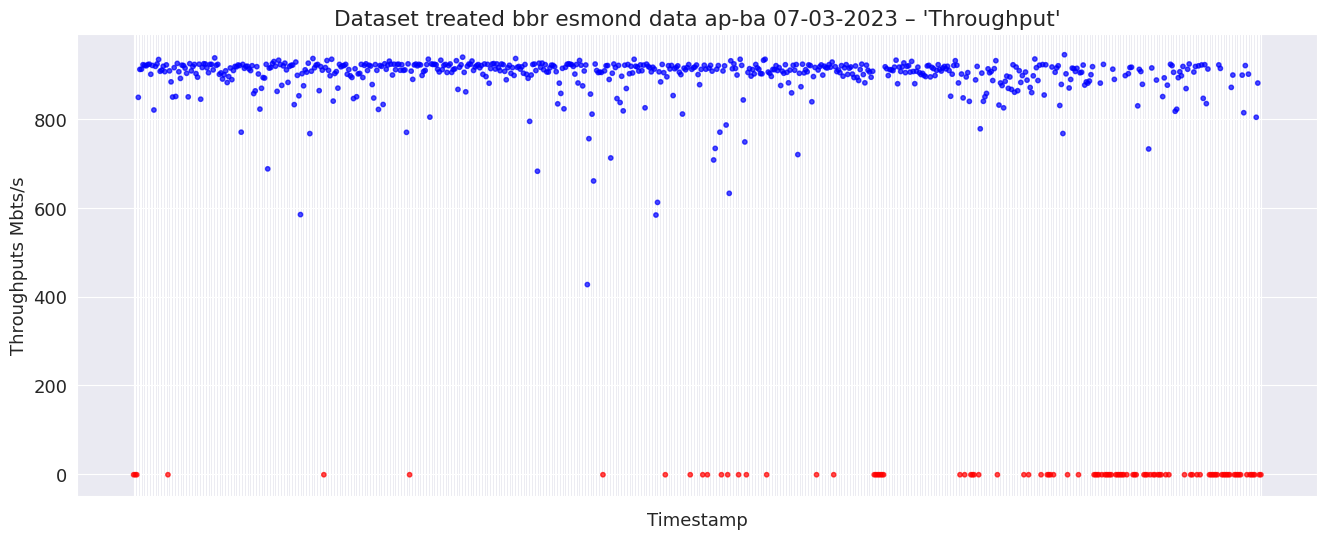

In [20]:
plot_df = df.copy().fillna(-1)
col = 'Throughput'

colors = np.where(plot_df[col] == -1, 'red', 'blue')

plt.scatter(plot_df.index, plot_df[col], c=colors, s=10, alpha=0.7)

plt.title(f"Dataset {name_df} – '{col}'")
plt.xlabel("Timestamp")
plt.xticks(ticks=plt.xticks()[0], labels=["" for _ in plt.xticks()[0]])
plt.ylabel('Throughputs Mbts/s')
plt.show()

In [21]:
# False -> missing values
mask_total = ~(df['Throughput'].isna()).values
print(f"Missing values mask:\n {mask_total}")

Missing values mask:
 [False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  Tru

In [22]:
threshold = int(len(df.index) * 0.8)

train_df = df.iloc[:threshold].copy()
print(f"Shape train {train_df.shape}")

test_df = df.iloc[threshold:].copy()
print(f"Shape test {test_df.shape}")

Shape train (579, 1)
Shape test (145, 1)


In [31]:
mask_test = mask_total[:threshold]
print(f"Shape test mask {mask_test.shape}")
print(f"Mask {mask_test[:10]}")

mask_train = mask_total[threshold:]
print(f"Shape train mask {mask_train.shape}")
print(f"Mask {mask_train[:10]}\n\n")

Shape test mask (579,)
Mask [False False False  True  True  True  True  True  True  True]
Shape train mask (145,)
Mask [ True  True  True False  True  True  True False False False]




In [ ]:
train_df['Throughput'] = train_df['Throughput'].interpolate(method='linear', limit_direction='both')
print(f"Train_df imputed: {train_df}\n Shape: {train_df.shape}")

Train_df imputed:                    Throughput
Timestamp                    
04-01-23 00:00:00  849.059003
04-01-23 06:00:00  849.059003
04-01-23 12:00:00  849.059003
04-01-23 18:00:00  849.059003
05-01-23 00:00:00  912.053206
...                       ...
27-05-23 12:00:00  879.576229
27-05-23 18:00:00  871.268244
28-05-23 00:00:00  859.843798
28-05-23 06:00:00  897.553796
28-05-23 12:00:00  935.421824

[579 rows x 1 columns]
 Shape: (579, 1)


In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_df[['Throughput']]) # O colchete duplo serve para não transformar a coluna em 'Series' (array) e manter como df

train_scaled = scaler.transform(train_df[['Throughput']])

train_scaled

array([[0.82329618],
       [0.82329618],
       [0.82329618],
       [0.82329618],
       [0.94627015],
       [0.94698708],
       [0.9668417 ],
       [0.96387685],
       [0.96188059],
       [0.96724741],
       [0.96919099],
       [0.92487761],
       [0.96361655],
       [0.76771909],
       [0.9595005 ],
       [0.97011642],
       [0.9897675 ],
       [0.93792898],
       [0.94293865],
       [0.95998487],
       [0.93628777],
       [0.96610987],
       [0.95291476],
       [0.93971964],
       [0.89146313],
       [0.82469515],
       [0.95394646],
       [0.82728738],
       [0.97247351],
       [0.93583212],
       [0.9066096 ],
       [0.96489851],
       [0.96307551],
       [0.95179552],
       [0.92907628],
       [0.82539592],
       [0.97144813],
       [0.939729  ],
       [0.9589095 ],
       [0.96807043],
       [0.92769167],
       [0.91209115],
       [0.96909022],
       [0.81521395],
       [0.95461076],
       [0.97111214],
       [0.97001515],
       [0.952

In [ ]:
test_scaled = scaler.transform(test_df[['Throughput']])

test_scaled

In [ ]:
LOOK_BACK = 3

Xs, ys = [], []
    
for i in range(len(X)-LOOK_BACK):
    v = train_scaled[i:i+LOOK_BACK]
    Xs.append(v)
    ys.append(train_scaled[i+LOOK_BACK])
    
np.array(Xs), np.array(ys)

In [ ]:
#gridsearch
def grid_search_cv(modelo, units, X_train, learning_rates, y_train, epochs_list, batch_sizes, patiences, model_name):
    best_loss = float('inf')
    best_params = {}
    for lr in learning_rates:
        for epochs in epochs_list:
            for batch_size in batch_sizes:
                for patience in patiences:
                    model = modelo(units, X_train, lr)
                    histories = fit_model_with_cross_validation(model, X_train, y_train, model_name, patience, epochs, batch_size)
                    mean_history = calculate_mean_history(histories)
                    val_loss = min(mean_history['val_loss'])
                    print("Val Loss: ", val_loss, "learning rate: ", lr, "epochs: ",  epochs, "batch_size: " , batch_size, "patience: ", patience)
                    if val_loss < best_loss:
                        best_loss = val_loss
                        best_params = {'learning_rate': lr, 'epochs': epochs, 'batch_size': batch_size, 'patience': patience} 
    print('O modelo '+model_name+ ' tem como melhores parametros os seguintes: learning_rate '+ str(best_params['learning_rate'])+' epochs: '+ str(best_params['epochs'])+' batch_size: '+ str(best_params['batch_size'])+ ' patience: '+ str(best_params['patience']))
    return best_params

#validação cruzada
def fit_model_with_cross_validation(model, xtrain, ytrain, model_name, patience, epochs, batch_size):
    tscv = TimeSeriesSplit(n_splits=5)
    fold = 1
    histories = []
    for train_index, val_index in tscv.split(xtrain):
        x_train_fold, x_val_fold = xtrain[train_index], xtrain[val_index]
        y_train_fold, y_val_fold = ytrain[train_index], ytrain[val_index]
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, min_delta=1e-5)
        history = model.fit(x_train_fold, y_train_fold, epochs=epochs, validation_data=(x_val_fold, y_val_fold), batch_size=batch_size, callbacks=[early_stop], verbose=1)
        print('\n\nTREINAMENTO - Fold', fold, 'do modelo:', model_name)
        histories.append(history)
        fold += 1   
    return histories 

# calcula a media das metricas obtidas nos historys - validação cruzada
def calculate_mean_history(histories):
    mean_history = {'loss': [], 'root_mean_squared_error': [], 'val_loss': [], 'val_root_mean_squared_error': []}
    for fold_history in histories:
        for key in mean_history.keys():
            mean_history[key].append(fold_history.history[key])
    for key, values in mean_history.items():
        max_len = max(len(val) for val in values)
        for i in range(len(values)):
            if len(values[i]) < max_len: #caso em que nao se treina todas as epocas (patience)
                values[i] += [values[i][-1]] * (max_len - len(values[i])) #completa o restante da lista com o ultimo valor obtido
    for key, values in mean_history.items():
        mean_history[key] = [sum(vals) / len(vals) for vals in zip(*values)]
    
    return mean_history


In [ ]:
best_params = grid_search_cv(
                        create_lstm, 64, X_train, [1e-3],
                        y_train, [100,300,500], [32, 64, 128], [5], 'LSTM'
                    )